<a href="https://colab.research.google.com/github/iamchenchu/Deep-Learnig-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine Tuning

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : Fine tuning


In [1]:
#Check if we are using the GPU

!nvidia-smi

Thu Dec 21 00:06:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Instead of creating helper functions every time, create them in one notebook and keep them available maybe in your github and download that helper functions to the current notebook and inport the respective functions as per your requirement.





In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-12-21 00:06:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-21 00:06:20 (50.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



**Note :** If you're running this notebook in google colab. when it times out Colab will delete `helper_functions.py`, so you will have to re download it, if you want to use the helper functions.


#Let's get some data

this time we're going to see how we can use the pretrained models ithin `tf.keras.applications` and apply them to our own problem (Recognizing images of food)

Link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of the training data of classes of Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the data

unzip_data("10_food_classes_10_percent.zip")




--2023-12-21 00:06:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.3MB/s    in 8.8s    

2023-12-21 00:06:33 (18.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#Check out how many images are there in the our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
# Create a training and test direcotry paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
# so far we were using ImageDataGenerator now let's use image_dataset_from_directory

import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
#Check out the class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of the data

for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.24331635e+02 1.13744896e+02 1.16505096e+02]
   [1.22265305e+02 1.12265305e+02 1.11408157e+02]
   [1.14494896e+02 1.05066322e+02 9.98520355e+01]
   ...
   [2.70050945e+01 1.01480389e+01 2.08725567e+01]
   [2.92653027e+01 1.95306568e+01 2.90510292e+01]
   [3.45256157e+01 3.05971508e+01 3.42399025e+01]]

  [[1.16591835e+02 1.06591835e+02 1.06397964e+02]
   [1.19729591e+02 1.09729591e+02 1.07877548e+02]
   [1.11214287e+02 1.01984695e+02 9.47142792e+01]
   ...
   [3.63264923e+01 1.96275749e+01 2.27245388e+01]
   [2.96478806e+01 1.78621922e+01 1.99335823e+01]
   [2.05459499e+01 1.30714970e+01 9.21424866e+00]]

  [[1.17132652e+02 1.07270409e+02 1.05137756e+02]
   [1.18403061e+02 1.09346939e+02 1.04515305e+02]
   [1.14168365e+02 1.05000000e+02 9.75714264e+01]
   ...
   [3.69743347e+01 1.82549744e+01 1.77345982e+01]
   [2.93009968e+01 1.36734486e+01 1.03009710e+01]
   [2.95714989e+01 1.60715332e+01 5.78571415e+00]]

  ...

  [[3.61327133e+01 2.43469753e+01 2.67755032e+01]
   [3

# Modeling Experiments we're running



# Model 0 : Building a transfer learning model usig the keras Functional API

The sequential API is straight-farward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models :

In [23]:
#1. Create base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

#2. Freeze the base model (so the underlying pre trained patterns aren't updated during the training)
base_model.trainable = False

#3. Create inputs into our model
inputs = tf.keras.Input(shape = (224,224, 3), name = "input_layer")

#4.  If using ResNet50V2 you will need to normalize inputs  (you don't have to do it for efficientNet(s))
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs to base model : {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after global average pooling : {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#8. Combine the inputs with the outputs into model
model_0 = tf.keras.Model(inputs, outputs)

#9. compile the model
model_0.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#10.Fit the model
history_10_percent=model_0.fit(train_data_10_percent,
            epochs =5,
            steps_per_epoch = len(train_data_10_percent),
            validation_data = test_data,
            validation_steps = int(0.25 * len(test_data)),
            callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                     experiment_name = "10_percent_feature_extraction")])




Shape after passing inputs to base model : (None, 7, 7, 1280)
Shape after global average pooling : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231221-002806
Epoch 1/5
24/24 [==============================] - 14s 307ms/step - loss: 1.8284 - accuracy: 0.4560 - val_loss: 1.3083 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 5s 178ms/step - loss: 1.0790 - accuracy: 0.7760 - val_loss: 0.8860 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - 5s 203ms/step - loss: 0.7840 - accuracy: 0.8307 - val_loss: 0.7309 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 5s 177ms/step - loss: 0.6300 - accuracy: 0.8520 - val_loss: 0.6314 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 181ms/step - loss: 0.5386 - accuracy: 0.8827 - val_loss: 0.5836 - val_accuracy: 0.8536


In [24]:
#Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5569 - accuracy: 0.8584


[0.5569186806678772, 0.8583999872207642]

In [25]:
#Check the layers in our base model

for number, layer in enumerate(base_model.layers):
  print(number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [26]:
#How about the getting the summary of our model

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['normalization_1

In [27]:
#how about a summary of our model
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

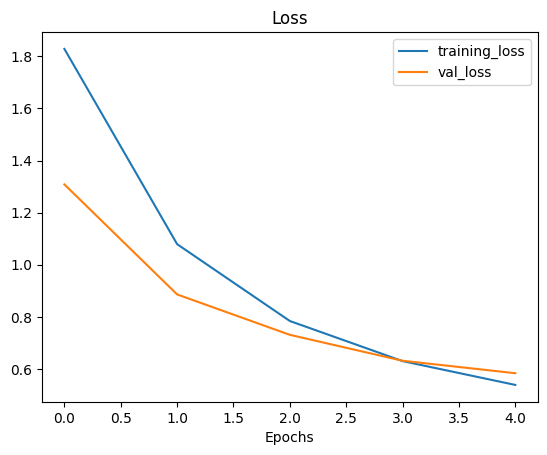

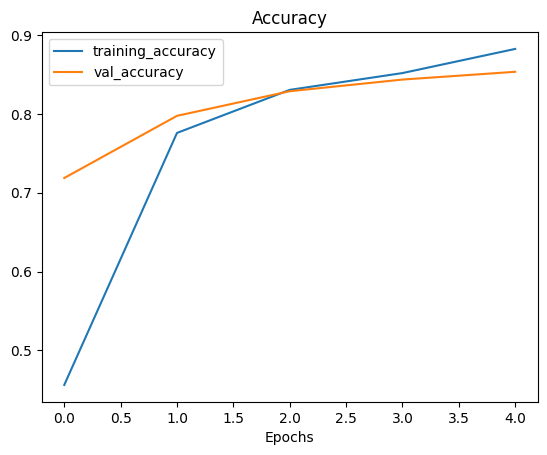

In [28]:
#Check out our model's training curves
plot_loss_curves(history_10_percent)

# Getting the feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.....

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAVeragePooling2D, it turns into (None,  1280).

Let's use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.



In [33]:
#define the input shape
input_shape = (1, 4, 4, 3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

#Check the shape of the different tensors
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor : {global_average_pooled_tensor.shape}")



Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor : (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor : (1, 3)


In [34]:
#Let's replicate the  GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice :** Try to do the same with the above two cells but this time use `GloabalMaxPool2D`... and see what happens.

`Note:` One of the resons feature extraction transfer learning is named how it is because what often happens is pretrained models outputs a feature vector(a long tensor of numbers which represents a learned representation of the model on a particular sample, in our case, this is the outpt of the `tf.keras.layers.GobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific probelem.


